# JAX demo: Can we clone a PHOENIX stellar model spectrum?

Let's demo using JAX for blasé.

In [1]:
from gollum.phoenix import PHOENIXSpectrum
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic stellar spectrum

The [gollum](http://gollum-astro.readthedocs.io) precomputed synthetic spectral model interface makes this step pretty straightforward.  You don't even need to have the file locally-- gollum can fetch it for you.

In [3]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

The pristine PHOENIX spectrum needs to be flattened to facilitate line finding:  We first divide out the black body and then divide by a $5^{th}$ order polynomial.

In [4]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()

Bummer, gollum is broken for some reason!!

In [5]:
#stellar_spectrum.fit_continuum()

Just do it manually...

In [6]:
from specutils.fitting import fit_generic_continuum
cont_norm_spec = stellar_spectrum / fit_generic_continuum(stellar_spectrum)(stellar_spectrum.spectral_axis) 

In [7]:
stellar_spectrum = cont_norm_spec.normalize(percentile=99)

(0.0, 1.1)

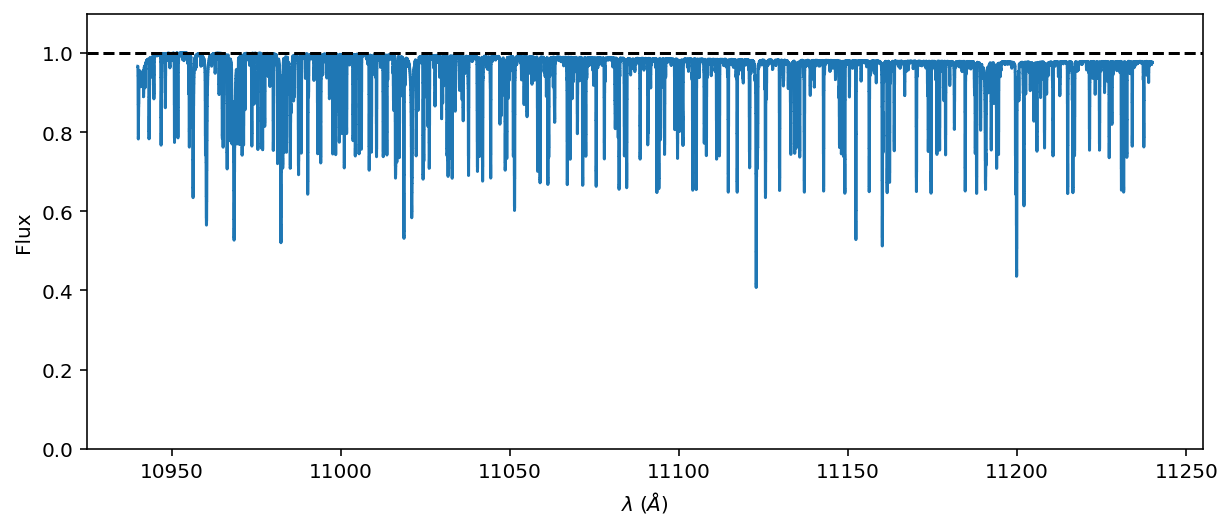

In [8]:
ax = stellar_spectrum.plot()
ax.axhline(1.0, color='k', linestyle='dashed')
ax.set_ylim(0.0,1.1)

Lame, its not a great continuum flattening.  Mine was better!!

## Clone the stellar model

We make an emulator for the spectrum by cloning all of the spectral lines above some prominence threshold:

In [9]:
import matplotlib.pyplot as plt

In [10]:
import math
import jax
import jax.numpy as jnp
import numpy as np
from scipy.signal import find_peaks, peak_prominences, peak_widths

In [11]:
flux_native = stellar_spectrum.flux.value
wl_native = stellar_spectrum.wavelength.value

In [12]:
prominence = 0.05

In [13]:
from blase.jaxemulator import LinearEmulator, SparseLinearEmulator

In [14]:
linear_emulator = LinearEmulator(wl_native, flux_native, prominence=prominence)

In [15]:
sparse_emulator = SparseLinearEmulator(wl_native, flux_native, prominence=prominence, wing_cut_pixels=300)

Initializing a sparse model with 214 spectral lines


In [16]:
vec = sparse_emulator.sigma_widths

In [17]:
jnp.expand_dims(vec, 0).shape

(1, 214)

In [19]:
sparse_emulator.forward()

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

(0.0, 1.1)

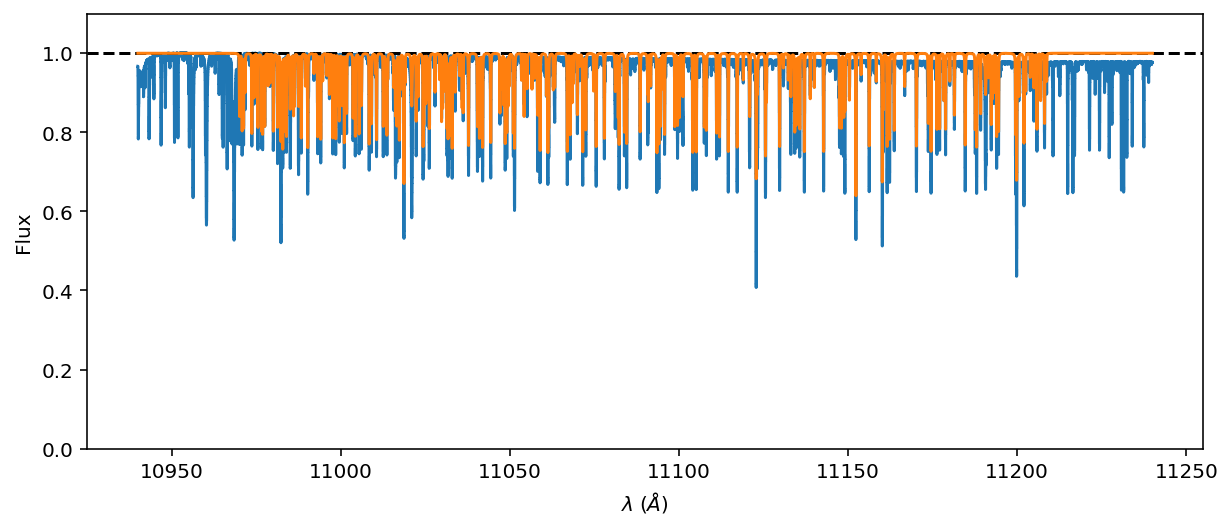

In [21]:
ax = stellar_spectrum.plot()
ax.axhline(1.0, color='k', linestyle='dashed')
ax.plot(wl_native, sparse_emulator.forward())
ax.set_ylim(0.0,1.1)

In [16]:
vector = prominences[42]*stats.norm.pdf(wl_native, loc = lam_centers[42], scale=0.5)

In [17]:
vector2 = stats.cauchy.pdf(wl_native, loc = lam_centers[42], scale=0.5)

(10970.0, 10990.0)

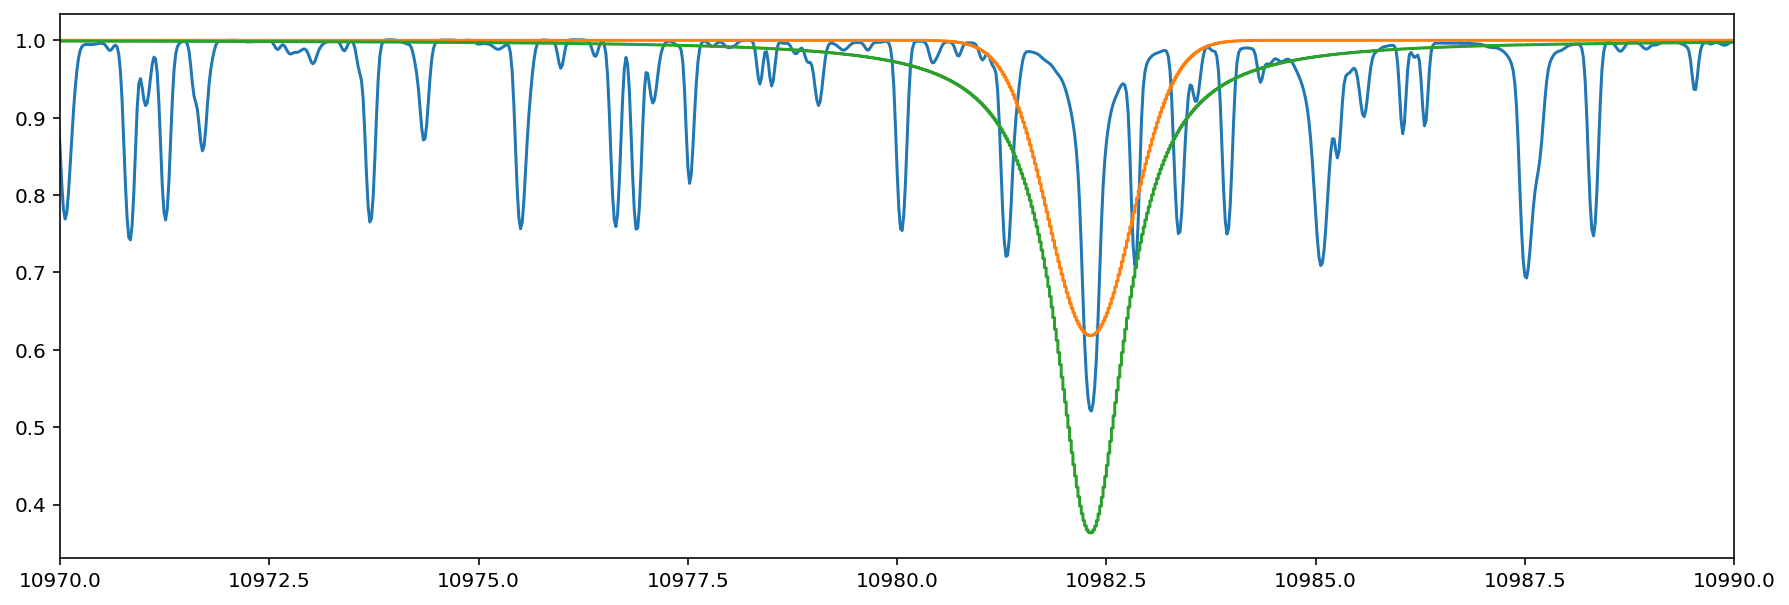

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(wl_native, flux_native)
plt.step(wl_native, 1-vector, '-')
plt.step(wl_native, 1-vector2, '-')
plt.xlim(10970, 10990)

In [55]:
def _lorentzian_line(lam_center, width, wavelengths):
    """Return a Lorentzian line, given properties"""
    return 1 / 3.141592654 * width / (width ** 2 + (wavelengths - lam_center) ** 2)

In [19]:
def _gaussian_line(lam_center, width, wavelengths):
    """Return a normalized Gaussian line, given properties"""
    return (
        1.0
        / (width * 2.5066)
        * jnp.exp(-0.5 * ((wavelengths - lam_center) / width) ** 2)
    )

In [20]:
_gaussian_line(lam_centers[14], widths_angs[14], wl_native)

DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [21]:
def _compute_eta(fwhm_L, fwhm):
    """Compute the eta mixture ratio for pseudo-Voigt weighting"""
    f_ratio = fwhm_L / fwhm
    return 1.36603 * f_ratio - 0.47719 * f_ratio ** 2 + 0.11116 * f_ratio ** 3

In [22]:
def _compute_fwhm(fwhm_L, fwhm_G):
    """Compute the fwhm for pseudo Voigt using the approximation
    """

    return (
        fwhm_G ** 5
        + 2.69269 * fwhm_G ** 4 * fwhm_L ** 1
        + 2.42843 * fwhm_G ** 3 * fwhm_L ** 2
        + 4.47163 * fwhm_G ** 2 * fwhm_L ** 3
        + 0.07842 * fwhm_G ** 1 * fwhm_L ** 4
        + fwhm_L ** 5
    ) ** (1 / 5)

In [ ]:
sigma_widths = widths_angstroms[mask] / math.sqrt(2) * sigma_width_tweak

In [67]:
def pseudo_voigt_profiles(wavelengths):
    r"""Compute the pseudo-Voigt Profile for a collection of lines

    Much faster than the exact Voigt profile, but not as accurate:
    """
    fwhm_G = 2.3548 * jnp.exp(sigma_widths).unsqueeze(1)
    fwhm_L = 2.0 * jnp.exp(gamma_widths).unsqueeze(1)
    fwhm = _compute_fwhm(fwhm_L, fwhm_G)
    eta = _compute_eta(fwhm_L, fwhm)

    return jnp.exp(self.amplitudes).unsqueeze(1) * (
        eta
        * _lorentzian_line(
            lam_centers.unsqueeze(1),
            jnp.exp(gamma_widths).unsqueeze(1),
            wavelengths.unsqueeze(0),
        )
        + (1 - eta)
        * _gaussian_line(
            lam_centers.unsqueeze(1),
            jnp.exp(self.sigma_widths).unsqueeze(1),
            wavelengths.unsqueeze(0),
        )
    )

In [68]:
pseudo_voigt_profiles(wl_native)

NameError: name 'sigma_widths' is not defined

In [6]:
%%capture
stellar_emulator = SparseLinearEmulator(stellar_spectrum.wavelength.value, 
                             stellar_spectrum.flux.value, 
                             wing_cut_pixels=6000, prominence=0.01, device=device)

The emulator found hundreds of spectral lines through a [heuristic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) process, and then instantiates a [Voigt profile](https://en.wikipedia.org/wiki/Voigt_profile) there.

In [7]:
len(stellar_emulator.lam_centers)

426

The `forward` pass of the model makes a spectrum that we can examine:

In [8]:
with torch.no_grad():
    stellar_pre = stellar_emulator.forward().cpu().numpy()

The initial guess should look lousy:

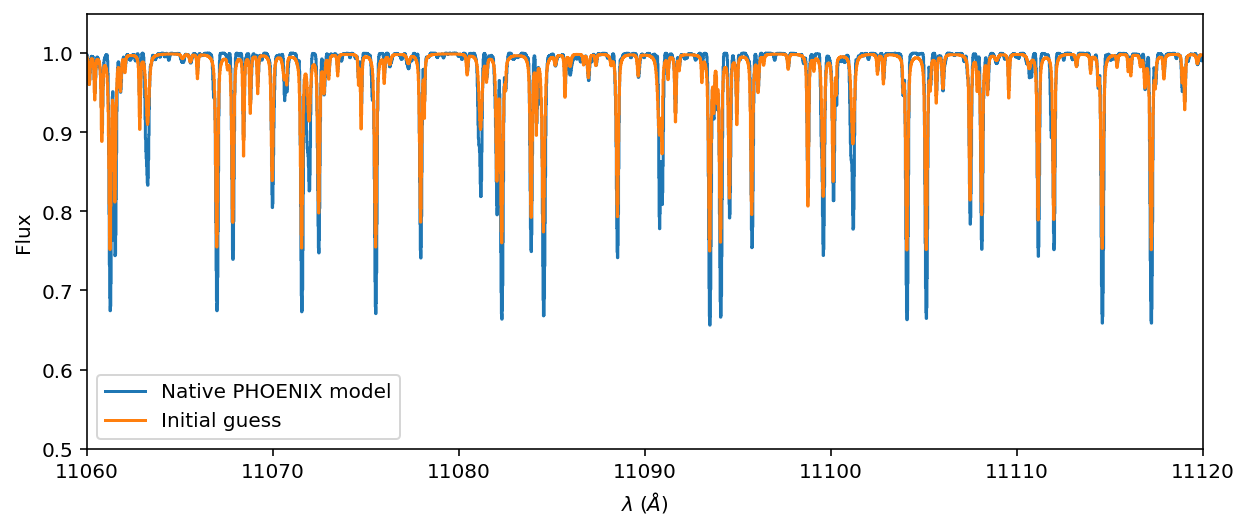

In [9]:
ax = stellar_spectrum.plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_pre, label='Initial guess')
ax.set_xlim(11_060, 11_120)
ax.legend();

The initialization is terrible! It's just a coarse guess that there is a line there with an approximate width and depth.  In the next step we will fine tune that guess.

### Fine-tune the model to clone the spectrum to near pixel-perfect

Here we adjust all of the properties of the lines simultaneously with the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm built into PyTorch.  Here we choose the bare minimum of 20 epochs with an aggressive learning rate (LR) of 0.05.  You should be able to get a better fit by running it for say 300 epochs, with a learning rate (LR) of 0.01, for example.  But it would take much longer.

In [10]:
stellar_emulator.optimize(epochs=20, LR=0.05)

Training Loss: 0.00022070: 100%|████████████████| 20/20 [00:29<00:00,  1.46s/it]


Now we can examine the spectrum, post fine-tuning.  It should provide a *much* better fit:

In [11]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()

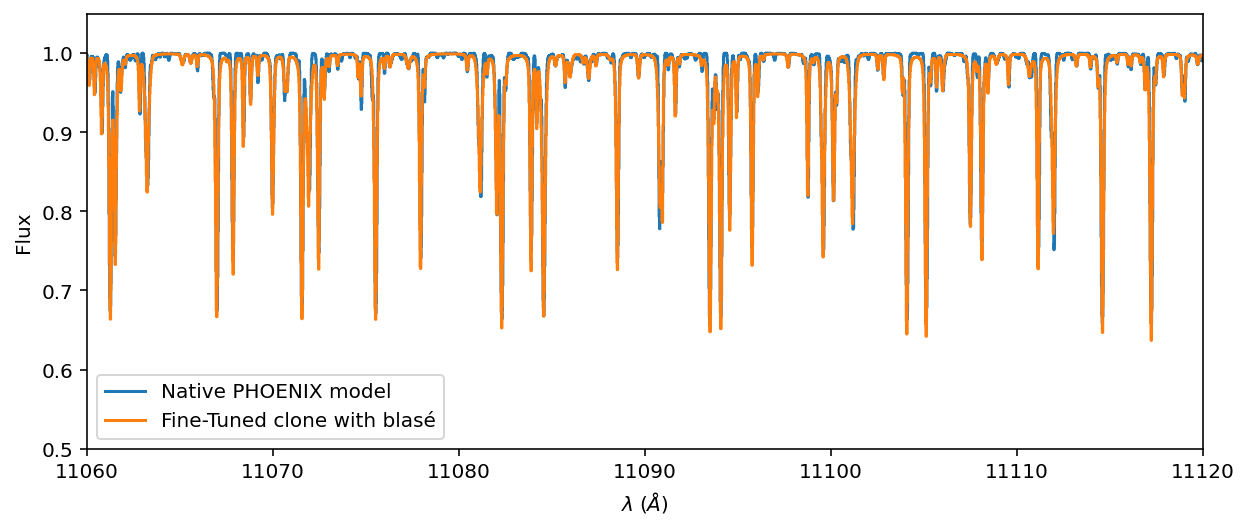

In [12]:
ax = stellar_spectrum.plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_post, label='Fine-Tuned clone with blasé')
ax.set_xlim(11_060, 11_120)
ax.legend();

Voilá! It's not perfect, but it's much better than before.  And recall that this is the clone at *native* resolution and pixel sampling.  Most models will ultimately be convolved with an instrumental kernel that will wash away most of these imperfections.

## Saving fine-tuned parameters as a "lookup table"

The collection of values for the wavelength centers, amplitudes, Gaussian widths, Lorentzian widths, and other parameters represents a reproducible snapshot of the model state:

> If you hand me the "lookup table" of these parameters, I can recreate the entire cloned forward model.  

In [13]:
torch.save(stellar_emulator.state_dict(), "phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt")